In [1]:
import matplotlib.pyplot as plt
import numpy as np 
import torch
import pickle
import pandas as pd

In [2]:
def get_quantile(samples,q,dim=1):
    return torch.quantile(samples,q,dim=dim).cpu().numpy()

In [3]:
unnormalization = True
device = torch.device('cuda:1')


nsample = 100 # number of generated sample
foldername = "PeMS7_V_228_20230531_161511_missing_pattern(RSM)_misssing_rate(0.1)"
path = './save_csdi/' + foldername + '/generated_outputs_nsample' + str(nsample) + '_epoch4' + '.pk' 
with open(path, 'rb') as f:
    samples,all_target,all_evalpoint,all_observed,_,_,_ = pickle.load( f)

samples = samples.to(device)
all_target = all_target.to(device)
all_evalpoint = all_evalpoint.to(device)
all_observed = all_observed.to(device)

all_target_np = all_target.cpu().numpy()
all_evalpoint_np = all_evalpoint.cpu().numpy()
all_observed_np = all_observed.cpu().numpy()
all_given_np = all_observed_np - all_evalpoint_np

# SM nodes, i.e., features shape (batch_size, L_d, K), (2, 288, 228)
# [0] not just one node/location, but just fetch the 1d array from the tuple
SM_inds = np.where(all_evalpoint_np[0,0,:] == 1)[0]
samples = samples[:,:,:,SM_inds]
all_target_np = all_target_np[:,:,SM_inds]
all_evalpoint_np = all_evalpoint_np[:,:,SM_inds]
all_observed_np = all_observed_np[:,:,SM_inds]
all_given_np = all_given_np[:,:,SM_inds]

K = samples.shape[-1] #feature
L = samples.shape[-2] #time length

if unnormalization:
    path = './save_csdi/' + foldername + '/meanstd.pk'
    with open(path, 'rb') as f:
        train_mean,train_std = pickle.load(f)
    
    # notice train_mean[SM_inds] should be all zeros, but here they have values
    train_mean = train_mean[SM_inds]
    train_std = train_std[SM_inds]

    train_std_cuda = torch.from_numpy(train_std).cuda(device=device)
    train_mean_cuda = torch.from_numpy(train_mean).cuda(device=device)
    all_target_np=(all_target_np*train_std+train_mean)
    samples=(samples*train_std_cuda+train_mean_cuda)

In [4]:
qlist =[0.05,0.25,0.5,0.75,0.95]
quantiles_imp= []
for q in qlist:
    quantiles_imp.append(get_quantile(samples, q, dim=1)*(1-all_given_np) + all_target_np * all_given_np)

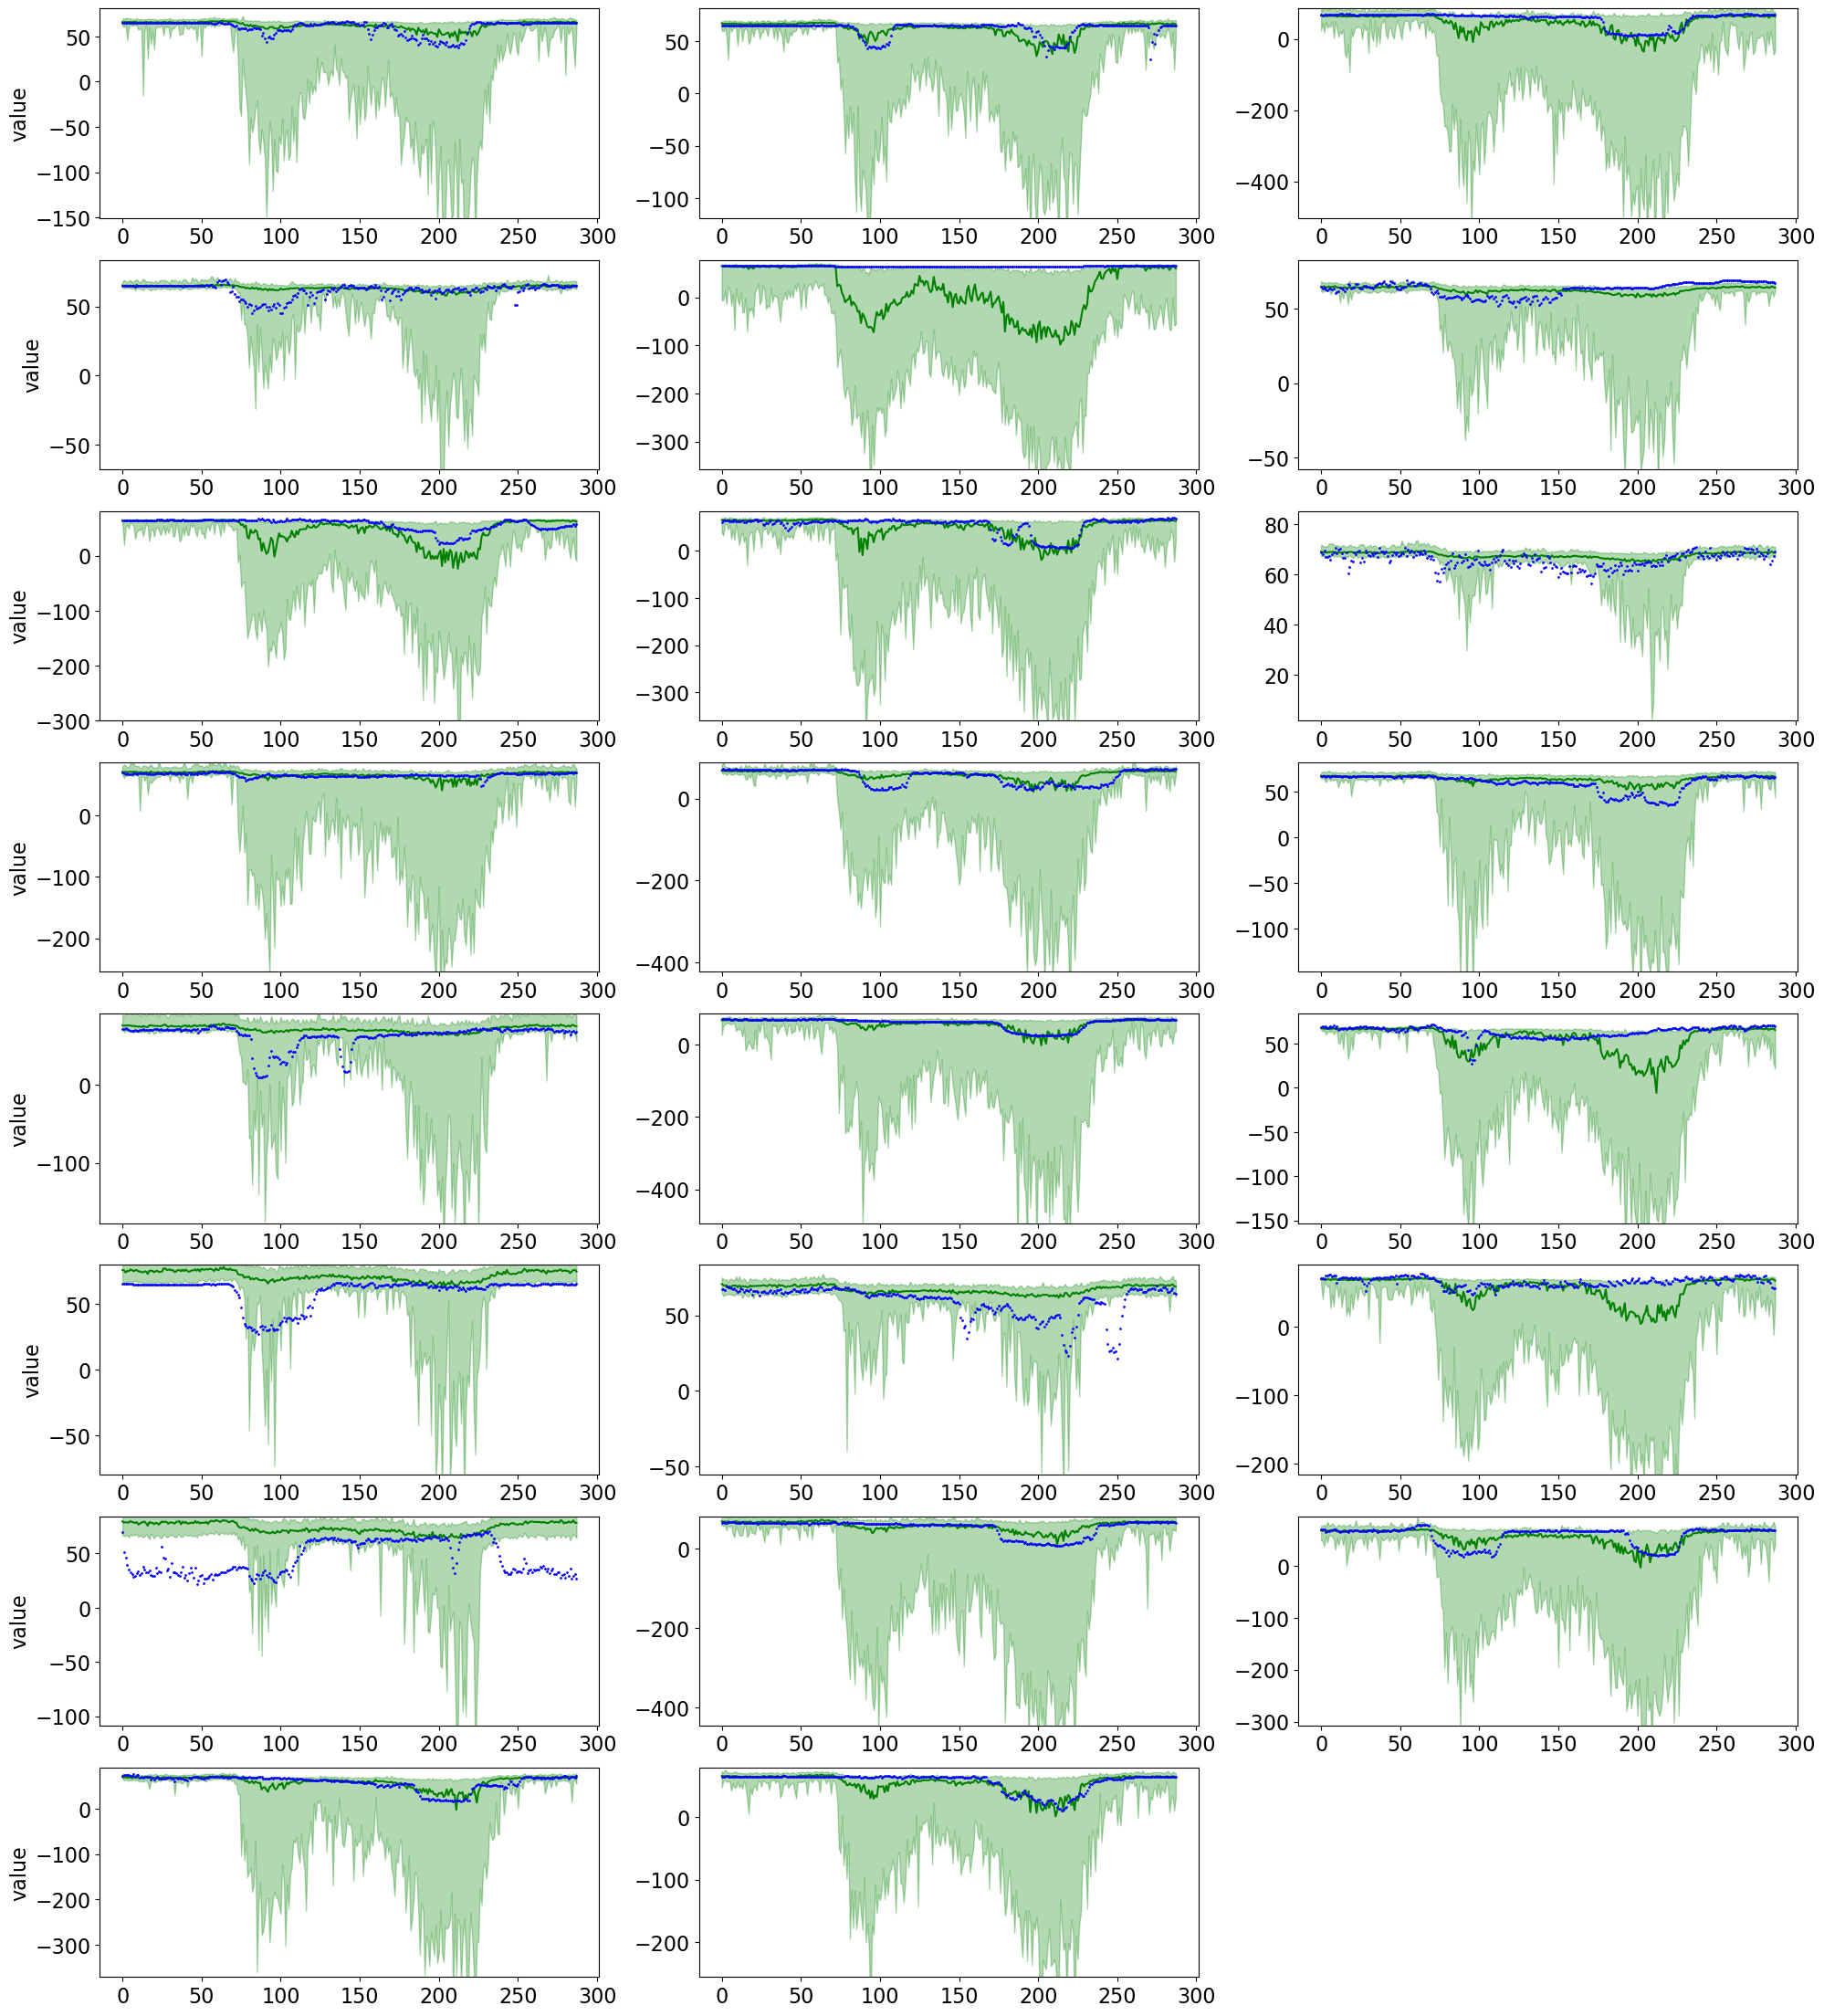

In [5]:
###traffic speed###
dataind = 0 #change to visualize a different sample
%matplotlib inline
plt.rcParams["font.size"] = 16

num_subplots = len(SM_inds)
ncols = 3
nrows = (num_subplots + ncols - 1) // ncols

fig, axes = plt.subplots(nrows=nrows, ncols=ncols,figsize=(24.0, 3.5*nrows))
fig.delaxes(axes[-1][-1])

for k in range(K):
    df = pd.DataFrame({"x":np.arange(0,L), "val":all_target_np[dataind,:,k], "y":all_evalpoint_np[dataind,:,k]})
    df = df[df.y != 0]
    df2 = pd.DataFrame({"x":np.arange(0,L), "val":all_target_np[dataind,:,k], "y":all_given_np[dataind,:,k]})
    df2 = df2[df2.y != 0]
    row = k // ncols
    col = k % ncols
    axes[row][col].plot(range(0,L), quantiles_imp[2][dataind,:,k], color = 'g',linestyle='solid',label='CDI')
    axes[row][col].fill_between(range(0,L), quantiles_imp[0][dataind,:,k],quantiles_imp[4][dataind,:,k],
                    color='g', alpha=0.3)
    axes[row][col].plot(df.x,df.val, color = 'b',marker = 'o', linestyle='None', markersize=1)
    axes[row][col].plot(df2.x,df2.val, color = 'r',marker = 'x', linestyle='None')

    # Get the minimum y-value from the data
    min_y = min(np.min(df.val), np.min(df2.val), np.min(quantiles_imp[0][dataind,:,k]))
    max_y = min(np.max(df.val), np.max(df2.val), np.max(quantiles_imp[4][dataind,:,k]))
    axes[row][col].set_ylim(bottom= min_y - min_y*0.2)  # Set the y-axis lower limit
    axes[row][col].set_ylim(top= max_y + max_y*0.2)  # Set the y-axis upper limit

    if col == 0:
        plt.setp(axes[row, 0], ylabel='value')
    if row == -1:
        plt.setp(axes[-1, col], xlabel='time')


In [6]:
SM_inds

array([ 16,  25,  59,  62,  64,  66,  70,  73,  86, 108, 112, 115, 127,
       141, 142, 162, 183, 196, 201, 205, 208, 209, 212], dtype=int64)